In [1]:
import pandas as pd
import sklearn

In [2]:
df_train = pd.read_excel('train_data.xlsx')
df_test = pd.read_excel('test_data.xlsx')

In [3]:
decimal_columns = ["IRR", "W_Avg", "Reduction"]
binary_columns = [
    "Vision",
    "Opt_Pw",
    "KPIs",
    "Bus_Int",
    "Gen_Bt",
    "Mgt_HR",
    "Org_Being",
    "Emp_Per",
    "Cor_Gov",
    "Out_Exp",
    "Cus_Exp",
    "FA_Opt",
    "Digi_Trans",
    "Del_Acct"
]
train_companies = df_train["company"].unique()

avgs = {col: df_train[col].mean() for col in decimal_columns}
stds = {col: df_train[col].std() for col in decimal_columns}

In [4]:
def process_data(df, avgs, stds):
    df_processed = pd.DataFrame()

    for i in range(len(df)):
        current_row = df.iloc[i]
        processed_row = {"company_" + company: 0 for company in train_companies}
        processed_row["company_other"] = 0

        if current_row["company"] in train_companies:
            processed_row["company_" + current_row["company"]] = [1]
        else:
            processed_row["company_other"] = [1]

        processed_row["fund_is_MEF_III"] = 1 if current_row["fund"] == "MEF III" else 0

        processed_row["Lead_Own_no"] = 1 if current_row["Lead_Own"] == 0 else 0
        processed_row["Lead_Own_yes"] = 1 if current_row["Lead_Own"] == 1 else 0
        processed_row["Lead_Own_nan"] = 1 if pd.isna(current_row["Lead_Own"]) else 0

        processed_row["Lead_Own_old_no"] = 1 if current_row["Lead_Own_old"] == 0 else 0
        processed_row["Lead_Own_old_yes"] = 1 if current_row["Lead_Own_old"] == 1 else 0
        processed_row["Lead_Own_old_nan"] = 1 if pd.isna(current_row["Lead_Own_old"]) else 0

        df_processed = pd.concat((df_processed, pd.DataFrame(processed_row)))    

    for col in decimal_columns:
        df_processed[col + "_normalized"] = (df[col].values - avgs[col]) / stds[col]

    for col in binary_columns:
        df_processed[col] = df[col].values

    return df_processed

In [5]:
df_train_processed = process_data(df_train, avgs, stds)

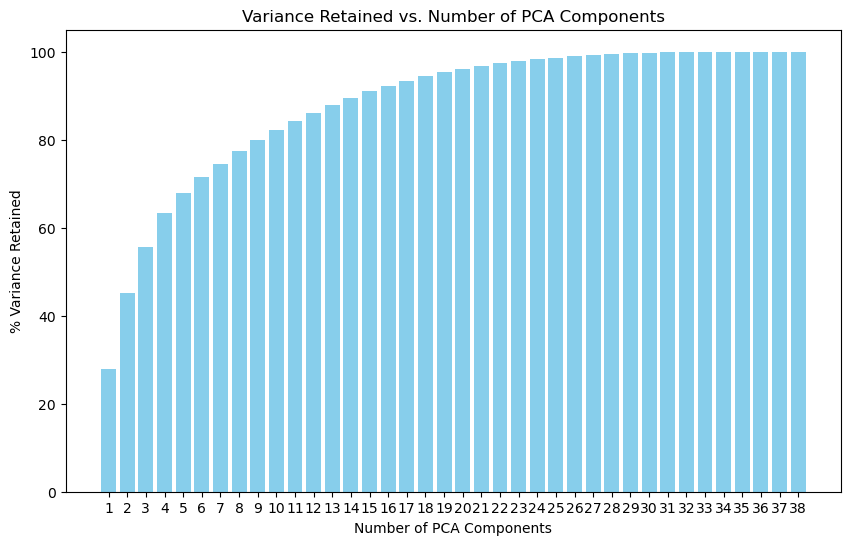

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Try all possible numbers of components, up to the min(n_samples, n_features)
max_components = min(df_train_processed.shape)
explained_variance_ratios = []

components_range = range(1, max_components + 1)
for n in components_range:
    pca = PCA(n_components=n, random_state=42)
    pca.fit(df_train_processed)
    explained_variance_ratios.append(pca.explained_variance_ratio_.sum())

# Convert to percent
percent_explained = np.array(explained_variance_ratios) * 100

plt.figure(figsize=(10,6))
plt.bar(components_range, percent_explained, color='skyblue')
plt.xlabel('Number of PCA Components')
plt.ylabel('% Variance Retained')
plt.title('Variance Retained vs. Number of PCA Components')
plt.xticks(components_range)
plt.ylim(0, 105)
plt.show()


In [7]:
def reduce_dimensionality(df, n_components):
    pca = PCA(n_components=n_components, random_state=42)
    reduced_array = pca.fit_transform(df)
    # Keep DataFrame for interpretability
    col_names = [f"PCA_{i+1}" for i in range(n_components)]
    return pd.DataFrame(reduced_array, index=df.index, columns=col_names)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500]
}

lr_base = LogisticRegression(random_state=42)

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    df_train_processed, df_train["Anomaly_label"], test_size=0.2, random_state=42, stratify=df_train["Anomaly_label"]
)

grid_search = GridSearchCV(
    lr_base, 
    param_grid, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_val_pred = best_model.predict(X_val)
val_f1 = f1_score(y_val, y_val_pred, average="macro")

print(f"Best Parameters: {best_params}")
print(f"Validation Macro F1: {val_f1:.4f}")


Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Macro F1: 1.0000


In [46]:
df_test_processed = process_data(df_test, avgs, stds)
test_preds = best_model.predict(df_test_processed)
submission = pd.DataFrame({"id": range(60, 100), "label": test_preds}).reset_index(drop=True)
submission.to_csv("submission.csv", index=False)